## Goal: improve performance of saxskit.saxs_math.spherical_normal_saxs()
(reduce the execution time while keeping reasonable accuracy)

In [1]:
import numpy as np
import pandas as pd
from time import time

In [2]:
from saxskit.saxs_math import spherical_normal_saxs # Compute SAXS intensity of a normally-distributed sphere population

spherical_normal_saxs() takes three required arguments: q (scattering vector array), r0 (mean sphere radius), and sigma (fractional standard deviation of sphere radii). 

Originally, spherical_normal_saxs() sampled sphere radii within **5** standard deviations of the mean, with a sampling resolution of **0.02** standard deviations. The intuition is that it is possible to have about the same accuracy using a smaller range and larger resolution. **This notebook seeks a smaller value for the range and larger value for the resolution, without significantly compromising the precision**. 

#### For this benchmark, we use a q-array from 0 to 0.5 1/Angstrom, with a step of 0.001 1/Angstrom.

In [3]:
q = np.arange(0, 0.5, 0.001)

#### We choose 10 r0 and 10 sigma values, totaling 100 size distributions for the benchmark. 

In [4]:
r0 = [1,5,20,25,30,50,100,200,1000]
sigma = [0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

#### Compute spherical_normal_saxs() with high sampling on all 100 distributions, and time it:

In [5]:
I = []
t0 = time()
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs(q,r,s, 5, 0.02))
print('time for computing spherical_normal_saxs()',
      'for all distributions, with high sampling:', 
      (time()-t0), "seconds.")

time for computing spherical_normal_saxs() for all distributions, with high sampling: 5.751904249191284 seconds.


Execution of spherical_normal_saxs() with high sampling takes several seconds (depends on computer). Let's try some different values the range and sampling resolution:

In [6]:
samp_width = np.arange(1, 5.5, 0.5)
samp_res = np.arange(0.02, 0.3, 0.02)

Now we can collect statistics about execution time and accuracy using different sampling:

In [7]:
stat = []
n_samp = len(r0) * len(sigma)
n_qpts = len(q)
for w in samp_width:
    for res in samp_res:
        I_new = []
        t0 = time()
        for r in r0:
            for s in sigma:
                I_new.append(spherical_normal_saxs(q,r,s,w,res))
        t = time()-t0

        #compare the result with the result that we got using high sampling:
        max_diff = [max(np.absolute(I[i]-I_new[i])) for i in range(n_samp)]
        abs_error = [sum(np.absolute(I[i]-I_new[i]))/n_qpts for i in range(n_samp)]
        max_abs_log_error = [max(np.log10(I[i])-np.log10(I_new[i])) for i in range(n_samp)]
        
        stat.append([w, res, t, np.mean(max_diff), np.mean(abs_error), np.mean(max_abs_log_error)])
stat = np.array(stat)

## Visualisation of the results

TODO: Make these plots with colored, with smaller dots, add lines, add legends

In [8]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
st = fig.suptitle("Execution time vs. sampling width and resolution", fontsize=20)

axes[0].scatter(stat[ : ,0],stat[ : ,2])
axes[1].scatter(stat[ : ,1],stat[ : ,2])
axes[0].set_ylabel('Time', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

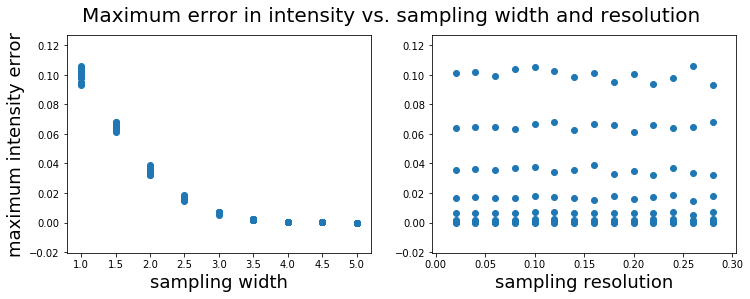

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
st = fig.suptitle("Maximum error in intensity vs. sampling width and resolution", fontsize=20)

axes[0].scatter(stat[ : ,0],stat[ : ,3])
axes[1].scatter(stat[ : ,1],stat[ : ,3])
axes[0].set_ylabel('maximum intensity error', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

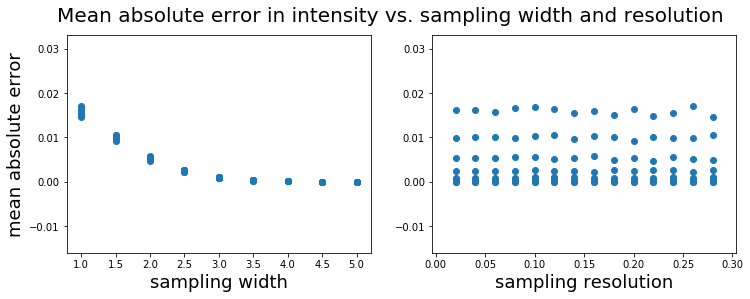

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
st = fig.suptitle("Mean absolute error in intensity vs. sampling width and resolution", fontsize=20)

axes[0].scatter(stat[ : ,0],stat[ : ,4])
axes[1].scatter(stat[ : ,1],stat[ : ,4])
axes[0].set_ylabel('mean absolute error', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

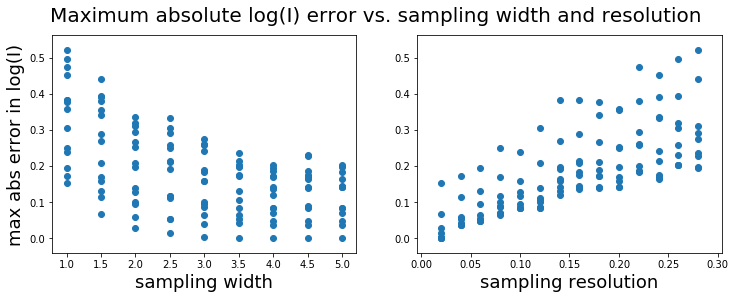

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
st = fig.suptitle("Maximum absolute log(I) error vs. sampling width and resolution", fontsize=20)

axes[0].scatter(stat[ : ,0],stat[ : ,5])
axes[1].scatter(stat[ : ,1],stat[ : ,5])
axes[0].set_ylabel('max abs error in log(I)', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('sampling width',fontsize=18)
axes[1].set_xlabel('sampling resolution', fontsize=18);

#### Analyzing the data above, we choose a sampling width of 3.5 standard deviations, and a resolution of 0.1 standard deviations.

TODO: justify this choice in the context of the plots above.

#### The execution time is reduced by a factor of 5 to 10 (depends on computer):

In [16]:
I_new = []
t0 = time()
for r in r0:
    for s in sigma:
        I_new.append(spherical_normal_saxs(q,r,s,3.5,0.1))
print('time for computing spherical_normal_saxs()',
      'for all distributions, with new sampling:', 
      (time()-t0), "seconds.")

time for computing spherical_normal_saxs() for all distributions, with new sampling: 0.8113119602203369 seconds.


In [17]:
I = [] # I calculated with original coefficients
for r in r0:
    for s in sigma:
        I.append(spherical_normal_saxs(q,r,s, 5, 0.02))


max_abs_log_error = []
for i in range(n_samp):
    max_abs_log_error.append(max(np.log10(I[i]) - np.log10(I_new[i])))
    
np.mean(max_abs_log_error)

0.08326990032263268

#### TODO: plot the distriubtion of max_abs_log_error